In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain

EDA (Exploratory Data Analysis) is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(10)



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
95729,00025181_015.png,Mass,15,25181,54,M,AP,3056,2544,0.139000,0.139000,NaN
8048,00002111_011.png,No Finding,11,2111,57,M,PA,2500,2048,0.171000,0.171000,NaN
94592,00024331_000.png,No Finding,0,24331,51,M,PA,2942,2991,0.143000,0.143000,NaN
111704,00030606_006.png,Emphysema|Pneumothorax,6,30606,59,M,PA,2021,2021,0.194311,0.194311,NaN
86948,00021457_016.png,Atelectasis|Effusion|Infiltration,16,21457,34,M,AP,3020,2544,0.139000,0.139000,NaN
82099,00020203_000.png,No Finding,0,20203,28,F,PA,2992,2991,0.143000,0.143000,NaN
17823,00004808_062.png,Infiltration,62,4808,35,M,PA,2992,2991,0.143000,0.143000,NaN
109797,00029866_010.png,No Finding,10,29866,57,F,PA,2021,2021,0.194311,0.194311,NaN
16643,00004461_001.png,No Finding,1,4461,40,M,PA,2992,2991,0.143000,0.143000,NaN
7280,00001926_000.png,No Finding,0,1926,56,M,AP,2500,2048,0.168000,0.168000,NaN


## EDA


In [3]:
# get all labels 
all_xray_df.columns


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [4]:
# shape of the df
print('The shape shows the totol rows and columns: ' + str(all_xray_df.shape))

# One of the columns is the image index
# verify if all names in the image_index are unique
print('Total number of unique entries in the df: ' + str(all_xray_df['Image Index'].nunique()))


The shape shows the totol rows and columns: (112120, 12)
Total number of unique entries in the df: 112120


In [5]:
# find the labels by splitting the "finding Labels" column into one disease
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [6]:
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

### EDA observation
The label "No Finding" has a score of 54%, and pneumonia is represented by only 1.28%.
Lets plot the data in a graph to make it more clear.

[Text(0, 0.5, 'Number of Images with Label')]

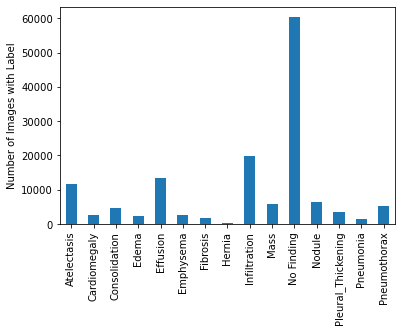

In [8]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Now it's even more clear that the most common label, "No Finding", has the biggest occurance. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

Since 'Infiltration' is the most common, I'm going to now look at how frequently it appears with all of the other diseases:

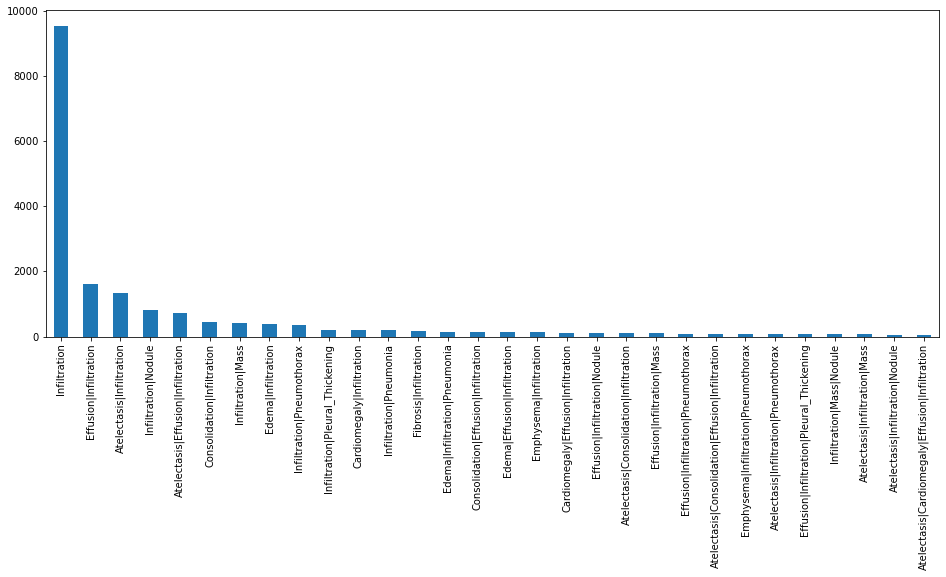

In [9]:
# Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Infiltration==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

### EDA Observation
As next lets look at the age and gender, etc

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

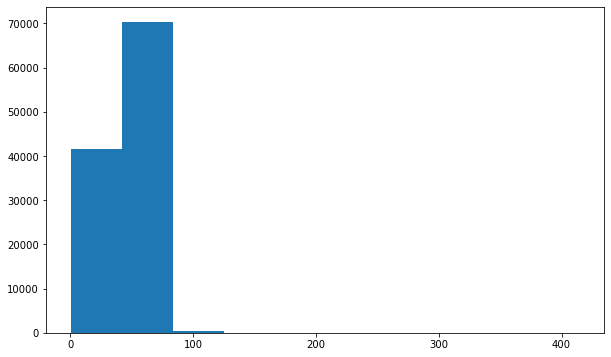

In [10]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'])

Most the age distribution is between 0 and 90, according wikipedia: https://en.wikipedia.org/wiki/Oldest_people, the oldest person is Jeanne Calment with an unbelievable age of 122 years and and 164 days. Therefore we will remove all records where the age is more then 122 years. 

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

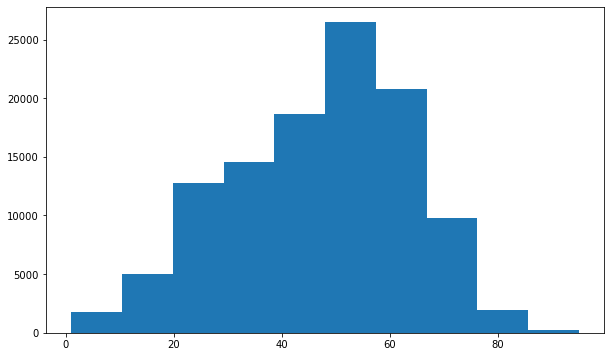

In [11]:
df = all_xray_df[all_xray_df["Patient Age"] < 122]
plt.figure(figsize=(10,6))
plt.hist(df["Patient Age"])

### EDA Observation
Lets look at the age group where most of patients were labeled with "pneumonia"

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

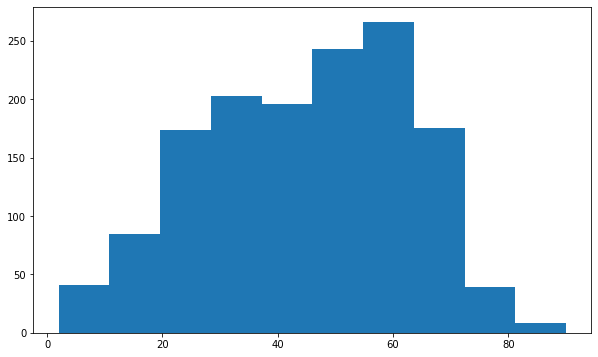

In [12]:
plt.figure(figsize=(10,6))
plt.hist(df["Patient Age"][df["Pneumonia"]==1])

(array([837.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

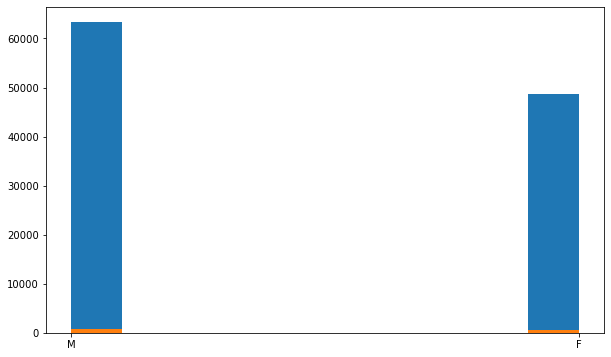

In [13]:
plt.figure(figsize=(10,6))
plt.hist(df["Patient Gender"])
plt.hist(df["Patient Gender"][df["Pneumonia"]==1])

(array([837.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

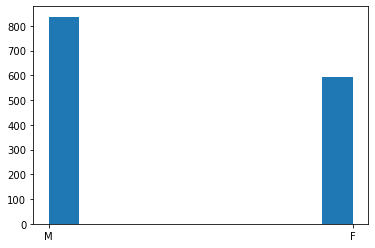

In [14]:
plt.hist(df["Patient Gender"][df["Pneumonia"]==1])

There are more male then female with pneumonia,but on the the full scale pneumonia only counts for a small perentage (1.3%), but it would be also interesting to see the frequencies of pneunomia with another desease. The code is similar as the code where we showed all 30 labels but this time we plot the most common 10 labels combined it with pneumonia

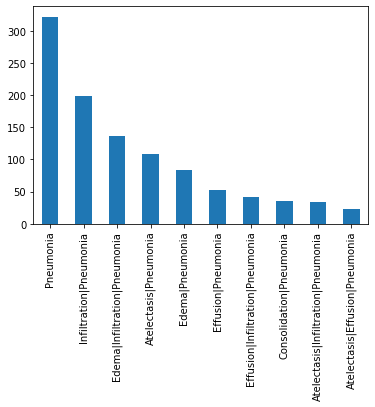

In [15]:
df[df.Pneumonia == 1]["Finding Labels"].value_counts()[:10].plot(kind='bar')

### EDA Observation
Next to pneumonia itself the most frequent combination is:
* Pneumonia combined with:
  * Infiltration
  * Edema and infiltration
  * Atelectasis

# Part 2 of EDA: Image Analysis

In [16]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(10)
#print(len(sample_df))

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5384,00029066_000.png,No Finding,0,29066,042Y,F,PA,2021,2021,0.194311,0.194311
5193,00027726_025.png,Infiltration,25,27726,058Y,M,AP,3056,2544,0.139000,0.139000
2544,00012815_001.png,No Finding,1,12815,050Y,F,PA,2544,3056,0.139000,0.139000
160,00000915_004.png,Infiltration,4,915,022Y,F,AP,2500,2048,0.171000,0.171000
3143,00015503_002.png,No Finding,2,15503,059Y,M,AP,2500,2048,0.168000,0.168000
2083,00010772_007.png,Effusion,7,10772,070Y,M,PA,2992,2991,0.143000,0.143000
2146,00011065_007.png,No Finding,7,11065,066Y,M,PA,2992,2991,0.143000,0.143000
5534,00030167_001.png,Consolidation,1,30167,056Y,M,AP,3056,2544,0.139000,0.139000
5587,00030606_013.png,Pneumothorax,13,30606,059Y,M,PA,2021,2021,0.194311,0.194311
3445,00016986_008.png,No Finding,8,16986,045Y,M,AP,2500,2048,0.168000,0.168000


In [17]:
# the images are stored in a image_ subfolder under data. 
# add a new column with the correct path to the image

image_paths = []
image_paths = {os.path.basename(x): x for x in
               glob(os.path.join('/data','images*','images','*.png'))}
print('Number of images loacated in the /data path: ' + str(len(image_paths)))
for i in list(image_paths)[0:3]:
    print ('the loaction of the path: ' + image_paths[i])

sample_df["Image Path"] = sample_df["Image Index"].map(image_paths.get)
sample_df.sample(10)

Number of images loacated in the /data path: 112120
the loaction of the path: /data/images_009/images/00019124_042.png
the loaction of the path: /data/images_009/images/00019576_024.png
the loaction of the path: /data/images_009/images/00019545_003.png


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Image Path
4178,00020482_061.png,Edema|Infiltration|Pneumonia,61,20482,029Y,F,AP,2500,2048,0.168,0.168,/data/images_009/images/00020482_061.png
1736,00009147_000.png,No Finding,0,9147,052Y,M,PA,2500,2048,0.168,0.168,/data/images_004/images/00009147_000.png
4223,00020745_001.png,Pleural_Thickening,1,20745,040Y,F,PA,2992,2991,0.143,0.143,/data/images_009/images/00020745_001.png
2282,00011693_000.png,Pleural_Thickening,0,11693,062Y,M,PA,3056,2544,0.139,0.139,/data/images_006/images/00011693_000.png
4149,00020405_003.png,Infiltration,3,20405,048Y,M,PA,2698,2991,0.143,0.143,/data/images_009/images/00020405_003.png
1531,00008005_001.png,No Finding,1,8005,062Y,F,PA,2048,2500,0.168,0.168,/data/images_004/images/00008005_001.png
4090,00020170_004.png,No Finding,4,20170,051Y,M,AP,3056,2544,0.139,0.139,/data/images_009/images/00020170_004.png
2080,00010767_008.png,Atelectasis|Pneumothorax,8,10767,058Y,M,AP,2500,2048,0.168,0.168,/data/images_005/images/00010767_008.png
2957,00014545_003.png,No Finding,3,14545,036Y,F,AP,2500,2048,0.168,0.168,/data/images_007/images/00014545_003.png
733,00003843_000.png,Atelectasis,0,3843,049Y,M,AP,2500,2048,0.171,0.171,/data/images_002/images/00003843_000.png


### Explore some random images with patients that are labeled with only Pneumonia

In [18]:
def pixel_level_assessment(label):
    for i in range(len(label)):
        image = plt.imread(label[i])
        axes[0][i].imshow(image,cmap='gray')
        axes[1][i].hist(image.ravel(), bins=256)

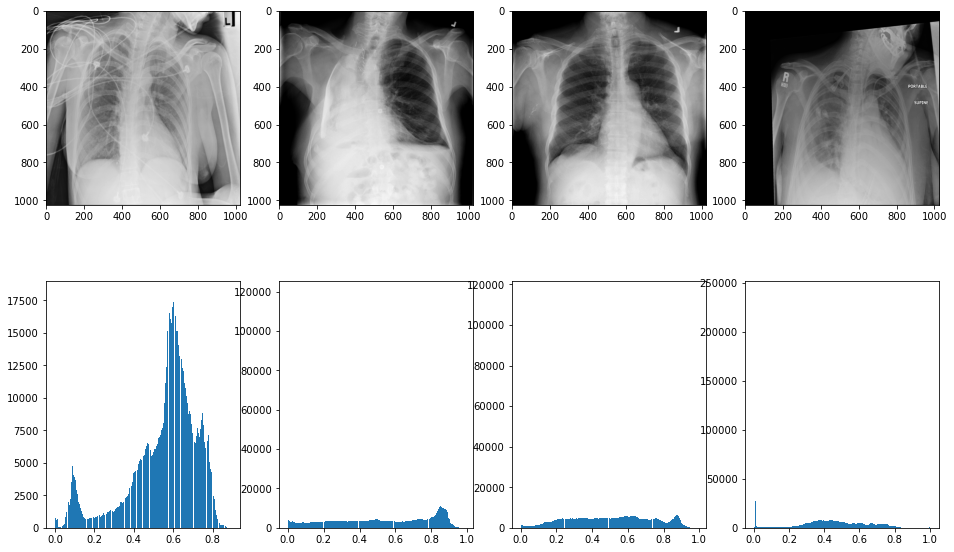

In [19]:
# Explore Random pictures labeled with only pneumonia
fig, axes = plt.subplots(2,4, figsize=(16,10))
pneumonia = sample_df[sample_df['Finding Labels']=="Pneumonia"]['Image Path'].sample(4).to_list()

pixel_level_assessment(pneumonia)

### lets look at the combinations that we discovered earlier
* Infiltration|Pneumonia
* Edema|Infiltration|Pneumonia
* Atelectasis|Pneumonia


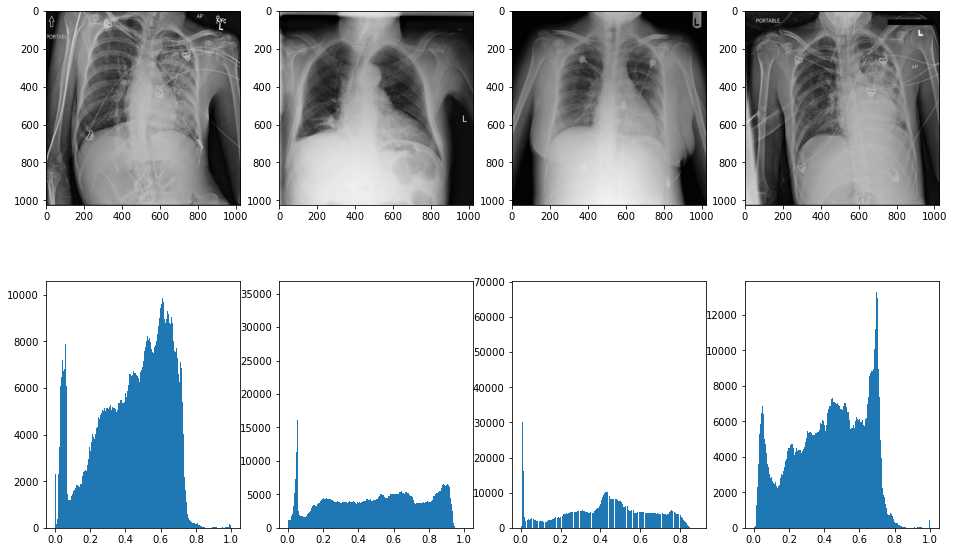

In [20]:
# Explore Random pictures labeled with infiltration and pneumonia
fig, axes = plt.subplots(2,4, figsize=(16,10))
infiltration_pneumonia = sample_df[sample_df['Finding Labels']=="Infiltration|Pneumonia"]['Image Path'].sample(4).to_list()

pixel_level_assessment(infiltration_pneumonia)


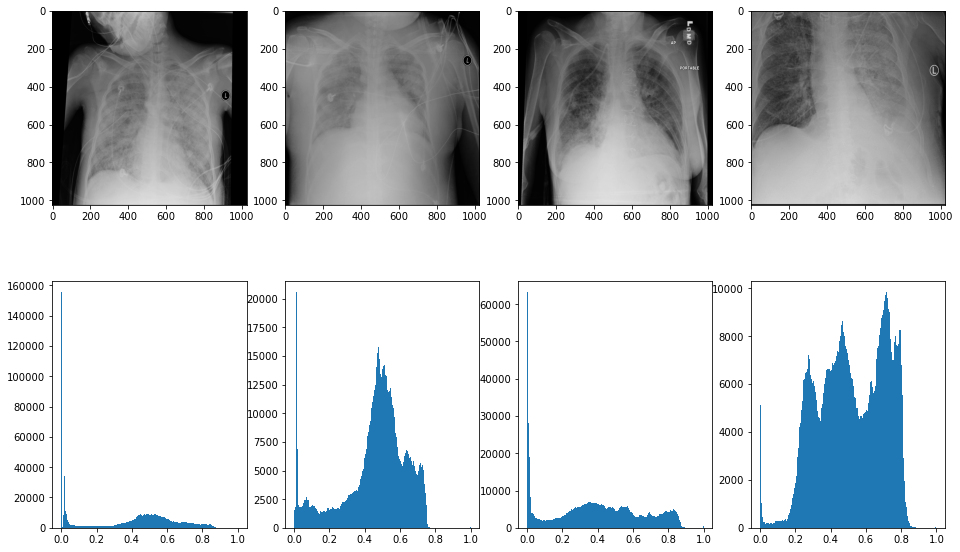

In [21]:
# Explore Random pictures labeled with Edema, infiltration and pneumonia
fig, axes = plt.subplots(2,4, figsize=(16,10))
edema_infiltration_pneumonia = sample_df[sample_df['Finding Labels']=="Edema|Infiltration|Pneumonia"]['Image Path'].sample(4).to_list()

pixel_level_assessment(edema_infiltration_pneumonia)

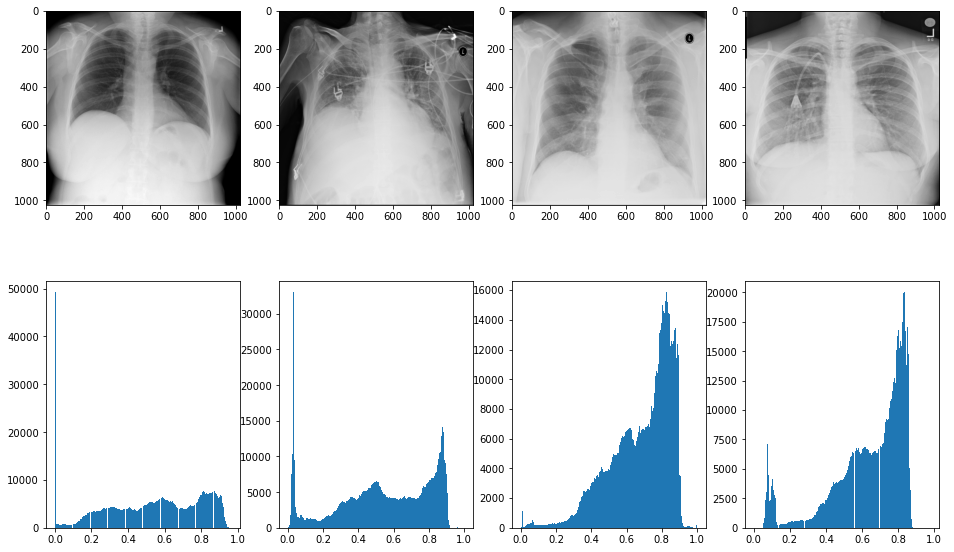

In [22]:
# Explore Random pictures labeled with Atelectasis and pneumonia
fig, axes = plt.subplots(2,4, figsize=(16,10))
atelectasis_pneumonia = sample_df[sample_df['Finding Labels']=="Atelectasis|Pneumonia"]['Image Path'].sample(4).to_list()

pixel_level_assessment(atelectasis_pneumonia)

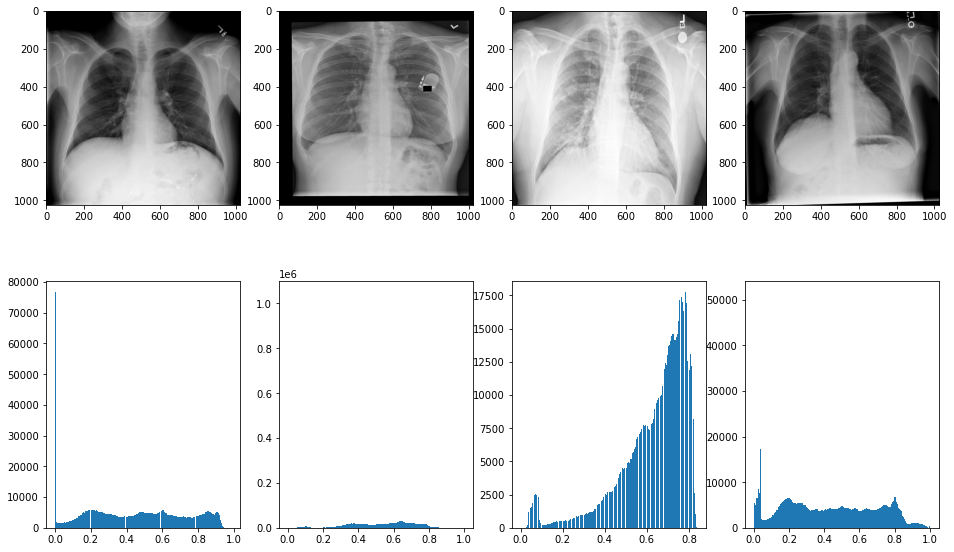

In [23]:
# Explore Random pictures labeled with No Finding
fig, axes = plt.subplots(2,4, figsize=(16,10))
no_finding = sample_df[sample_df['Finding Labels']=="No Finding"]['Image Path'].sample(4).to_list()

pixel_level_assessment(no_finding)

### EDA Observation
There are some spikes near the 0 and it probably is due to the background intensity
Apart from the background spikes there are other intensities, and if you're not a trained radiology then it seems impossible to differentiate whether the patient has pneumonia or another desease. Foreign objects can also have an effect on the intensity level.  